In [7]:
# Fraude - Classificacao com RandomForest e ajustes para classe rara

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, precision_score, classification_report, make_scorer, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
# 1. Carregamento dos dados
train_df = pd.read_excel("Train Fraud.xlsx")
test_df = pd.read_excel("Test Fraud - Alunos.xlsx")

# Identificar colunas
target = 'Fraude'
features = [col for col in train_df.columns if col != target]

In [9]:
# Separar colunas numéricas e categóricas
numerical_cols = train_df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

# Preenchimento de valores nulos
train_df[numerical_cols] = train_df[numerical_cols].fillna(train_df[numerical_cols].mean())
test_df[numerical_cols] = test_df[numerical_cols].fillna(train_df[numerical_cols].mean())

train_df[categorical_cols] = train_df[categorical_cols].fillna("desconhecido")
test_df[categorical_cols] = test_df[categorical_cols].fillna("desconhecido")

# Tratar alta e baixa cardinalidade
low_cardinality = [col for col in categorical_cols if train_df[col].nunique() <= 10]
high_cardinality = [col for col in categorical_cols if train_df[col].nunique() > 10]

In [10]:
# Label Encoding manual para alta cardinalidade
for col in high_cardinality:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# One-hot encoding para baixa cardinalidade
train_df = pd.get_dummies(train_df, columns=low_cardinality)
test_df = pd.get_dummies(test_df, columns=low_cardinality)

# Alinhar colunas
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)


In [11]:
# Separar X e y
X = train_df.drop(columns=[target])
y = train_df[target]
X_test_final = test_df.copy()
if 'Fraude' in X_test_final.columns:
    X_test_final = X_test_final.drop(columns=['Fraude'])

# 1.1 Verificar variáveis suspeitas de vazamento  
corrs = X.corrwith(y).abs().sort_values(ascending=False)  
suspect_vars = corrs[corrs > 0.95].index.tolist()  
if suspect_vars:  
    print("Removendo variáveis com alta correlação com o target:", suspect_vars)  
    X.drop(columns=suspect_vars, inplace=True)  
    X_test_final.drop(columns=[col for col in suspect_vars if col in X_test_final.columns], inplace=True)  

# 2. Dividir em treino e validação
X_train_0, X_val, y_train_0, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 2.1 Garantir que y está no formato correto para SMOTE
y_train_0 = y_train_0.astype(int)  # <----

# 2.2 Aplicar SMOTE apenas ao conjunto de treino
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_train, y_train = sm.fit_resample(X_train_0, y_train_0)  # <----

In [13]:
# 3. Calcular scale_pos_weight (não usado em RF mas mantido para referência)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 4. RandomForest com GridSearch 
model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    class_weight=None,  # Pode ser 'balanced' ou um dicionário manual
    n_jobs=-1
)

param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 5],  # -1 significa sem limite
    'model__learning_rate': [0.01, 0.05],
    'model__num_leaves': [7, 15],  # idealmente 2^max_depth - 1
    'model__min_child_samples': [10, 20],  # min samples per leaf
    'model__min_child_weight': [1e-2, 0.1],  # penaliza folhas pequenas
    'model__subsample': [0.7, 1.0],  # bagging
    'model__colsample_bytree': [0.7, 1.0],  # feature sampling
    'model__scale_pos_weight': [scale_pos_weight, scale_pos_weight*0.5, scale_pos_weight*2],  # ajusta peso da classe minoritária
    'model__reg_alpha': [0, 0.1],  # L1 regularization
    'model__reg_lambda': [0, 0.1],  # L2 regularization
}

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

#Previsões de probabilidade no conunt de validação
probs = best_model.predict_proba(X_val)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_val, probs)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Melhor threshold: {best_threshold:.4f}")

KeyboardInterrupt: 

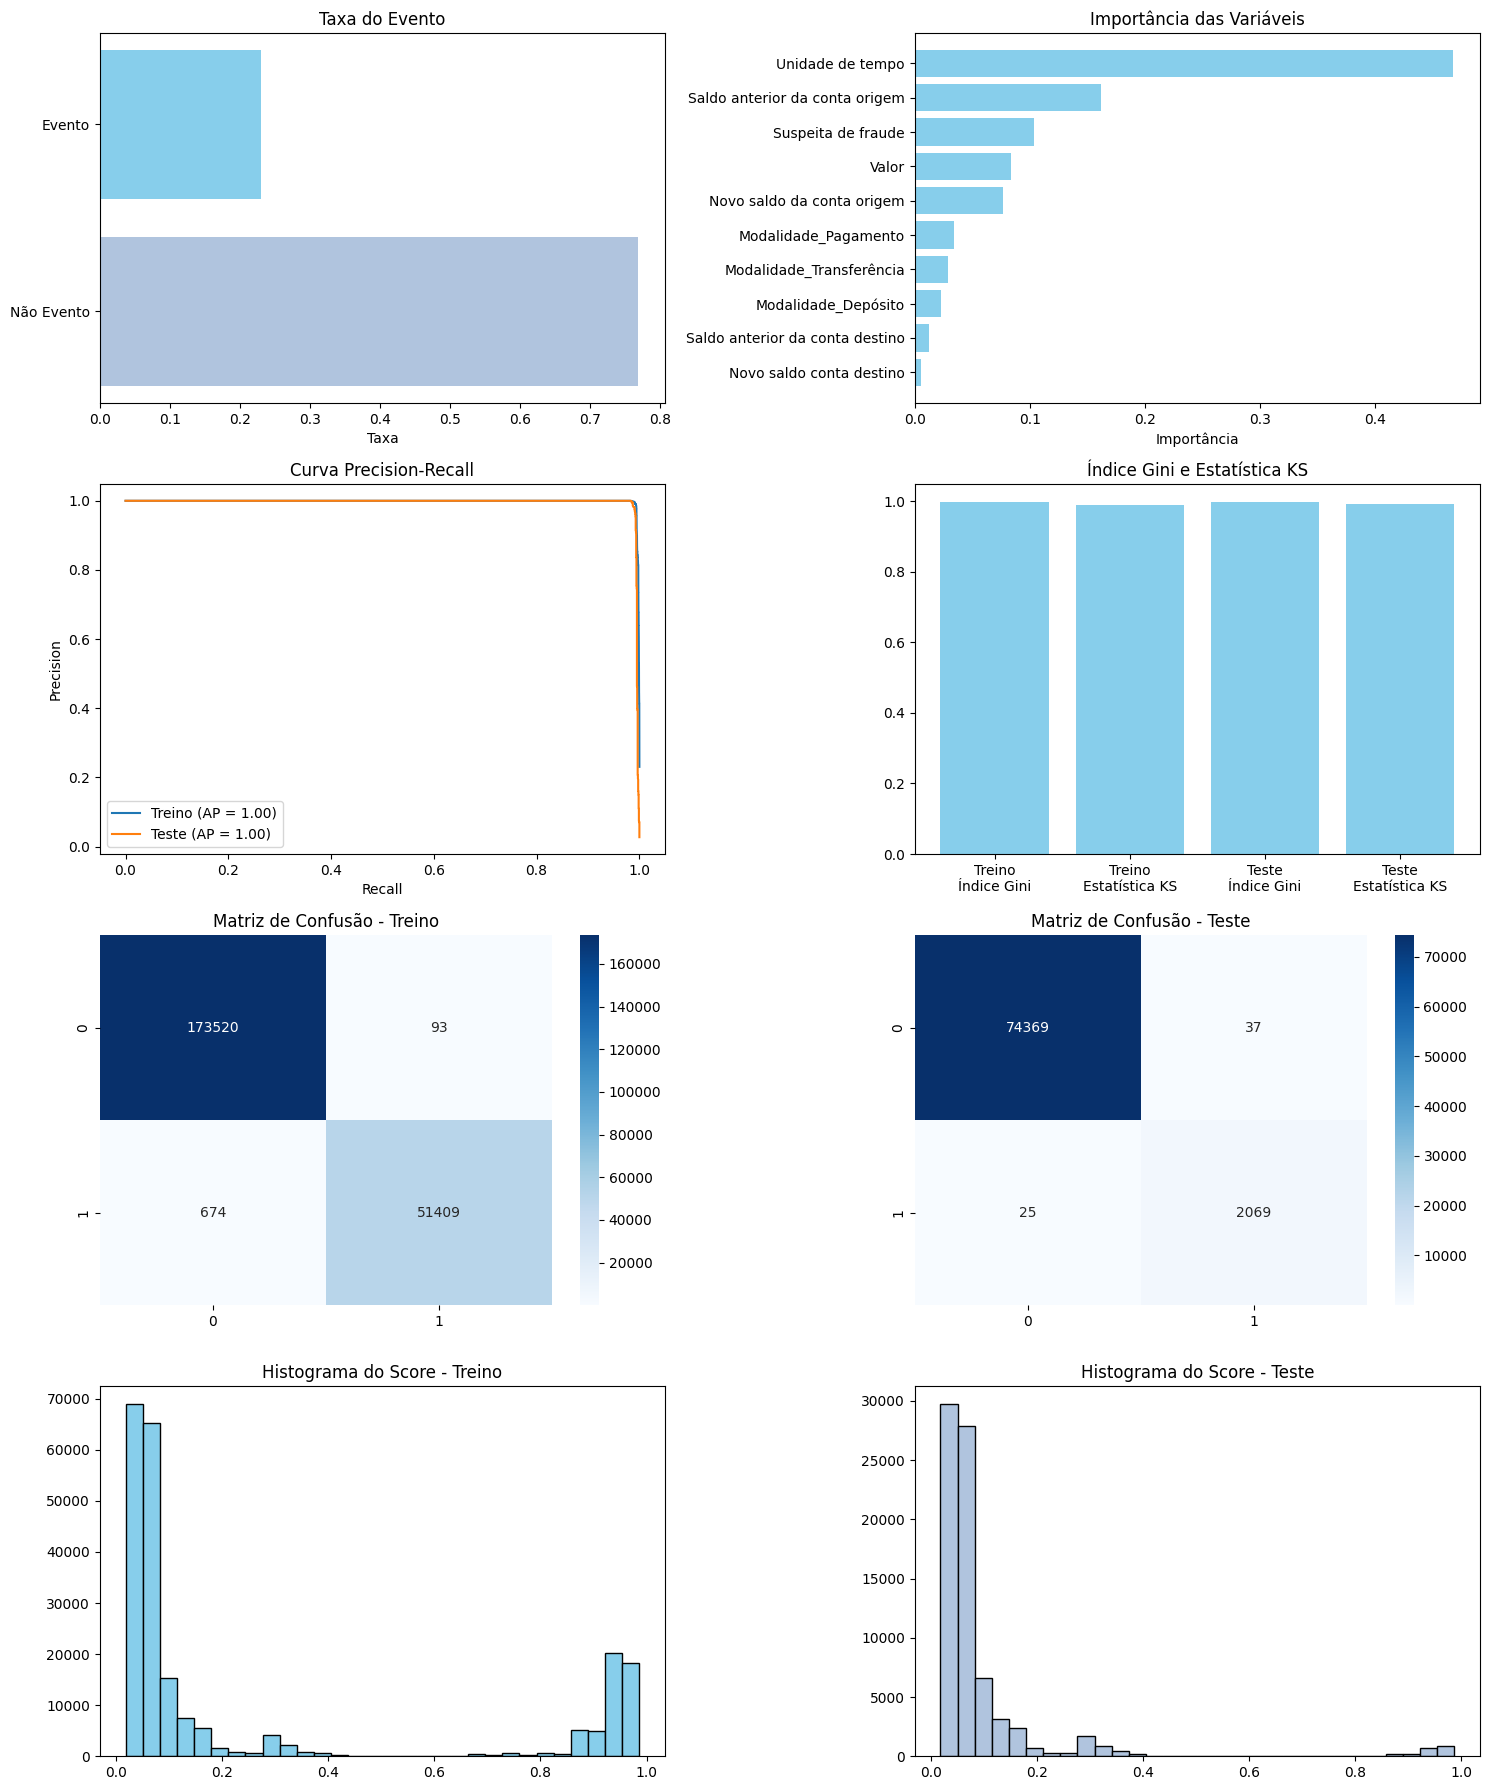

==Treino==
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    173613
           1       1.00      0.98      0.99     52083

    accuracy                           1.00    225696
   macro avg       1.00      0.99      0.99    225696
weighted avg       1.00      1.00      1.00    225696

==Teste==
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74406
           1       1.00      0.99      0.99      2094

    accuracy                           1.00     76500
   macro avg       1.00      0.99      1.00     76500
weighted avg       1.00      1.00      1.00     76500



In [ ]:
# 5. Avaliacao com funcao fornecida
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[-10:]
    plt.barh(np.array(features)[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    plt.subplot(4, 2, 3)  # <----
    for X_set, y_set, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probas = model.predict_proba(X_set)[:, 1]
        precision, recall, _ = precision_recall_curve(y_set, probas)
        ap_score = average_precision_score(y_set, probas)
        plt.plot(recall, precision, label=f'{label} (AP = {ap_score:.2f})')  # <----
    plt.xlabel('Recall')  # <----
    plt.ylabel('Precision')  # <----
    plt.title('Curva Precision-Recall')  # <----
    plt.legend()


    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X_set, y_set, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X_set)[:, 1]
        df = pd.DataFrame({'true_labels': y_set, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y_set, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    for i, (X_set, y_set, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        y_pred = (model.predict_proba(X_set)[:, 1] >= best_threshold).astype(int)  # <----
        conf_matrix = confusion_matrix(y_set, model.predict(X_set))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão - {label}')

    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black')
    plt.title('Histograma do Score - Treino')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black')
    plt.title('Histograma do Score - Teste')

    plt.tight_layout()
    plt.show()
    textstr = ""
    for X_set, y_set, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        y_pred = (model.predict_proba(X_set)[:, 1] >= best_threshold).astype(int)  # <----
        #y_pred = model.predict(X_set)
        precision = precision_score(y_set, y_pred)
        recall = recall_score(y_set, y_pred)
        f1 = f1_score(y_set, y_pred)
        textstr += f'{label}:\n Precision: {precision:.2f}\n| Recall: {recall:.2f}\n F1: {f1:.2f}\n\n'
        print(f'=={label}==')
        print(classification_report(y_set, y_pred))

plot_metrics(best_model, X_train, y_train, X_val, y_val, X.columns)

# 6. Prever com o threshold ajustado
final_probs = best_model.predict_proba(X_test_final)[:, 1]  # <----
test_pred = (final_probs >= best_threshold).astype(int)  # <----

In [ ]:
# 7. Gerar previsões finais
test_pred = best_model.predict(X_test_final)

# 8. Gerar planilha de submissão
submission = pd.DataFrame({
    'Fraude_Prevista': test_pred
})

submission.to_excel("submissao_final.xlsx", index=False)